***SAC** 算法也可以处理 **离散动作交互（车杆环境）** 的环境，但是要做一些相应的修改：*

导入相关库：

In [1]:
# 基本库
import numpy as np

from utils.replay_buffer import ReplayBuffer
from utils.training import train_off_policy_agent
from utils.smoothing import moving_average
# 神经网络
import torch
import torch.nn.functional as F

from torch.distributions import Normal
# Gymnasium 是一个用于开发和测试强化学习算法的工具库，为 OpenAI Gym 的更新版本（2021迁移开发）
import gymnasium as gym

### 定义策略网络和价值网络:
- **策略网络** 的输出修改为在离散动作空间上的 **softmax 分布**
- **价值网络** 直接接收状态和离散动作空间的分布作为输入，输出的是每种动作的价值

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

### 定义 SAC 算法（离散动作）：

In [3]:
class SAC:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 alpha_lr, target_entropy, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device) 
        self.target_critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device) 
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        # 使用alpha的log值,可以确保 α 永远是正数,使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau  # 软更新步长
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    # 计算目标Q值,直接用策略网络的输出概率进行期望计算
    def calc_target(self, rewards, next_states, dones):
        next_probs = self.actor(next_states)
        next_log_probs = torch.log(next_probs + 1e-8)
        entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True)  # 直接计算动作熵
        q1_value = self.target_critic_1(next_states)
        q2_value = self.target_critic_2(next_states)
        # 网络输出的是每种动作的价值，而非 状态动作对 的单一价值
        min_qvalue = torch.sum(next_probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)
        
        next_value = min_qvalue + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        
        return td_target

    # DDPG中的软更新
    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)  # 动作不再是float类型
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_q_values = self.critic_1(states).gather(1, actions)
        critic_1_loss = torch.mean(F.mse_loss(critic_1_q_values, td_target.detach()))
        critic_2_q_values = self.critic_2(states).gather(1, actions)
        critic_2_loss = torch.mean(F.mse_loss(critic_2_q_values, td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        probs = self.actor(states)
        log_probs = torch.log(probs + 1e-8)
        entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True)
        q1_value = self.critic_1(states)
        q2_value = self.critic_2(states)
        min_qvalue = torch.sum(probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - min_qvalue)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        # 软更新目标Q网络
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

### 环境设置（'CartPole-v1'）：

In [4]:
np.random.seed(0)    # 设置 NumPy 的随机种子
torch.manual_seed(0) # 设置 PyTorch CPU 随机种子
torch.cuda.manual_seed_all(0) # 设置 PyTorch GPU 随机种子, 由于GPU并行性, 只能极大减小偏差

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)   # 环境通常依赖于其他随机数生成器来初始化状态、进行探索(推荐位于以上随机之后)
print("Environment spec:", env.spec)


Environment spec: EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')


### 超参数设置：

In [5]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

target_entropy = -1 # 目标熵
hidden_dim = 128

actor_lr = 1e-3
critic_lr = 1e-2
alpha_lr = 1e-2
tau = 0.005  # 软更新参数
gamma = 0.98

device = torch.device("cuda") if torch.cuda.is_available() else torch.device( "cpu")

buffer_size = 10000
minimal_size = 500
batch_size = 64
replay_buffer = ReplayBuffer(buffer_size)

agent = SAC(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, alpha_lr,
            target_entropy, tau, gamma, device)

num_episodes = 200

### 测试与训练:

In [6]:
return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 20/20 [00:47<00:00,  2.38s/it, episode=200, return=178.800]


### 绘图：

In [7]:
import pandas as pd
episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 9)
# 创建 DataFrame
df1 = pd.DataFrame({'Episodes': episodes_list, 'Returns': return_list})
df2 = pd.DataFrame({'Episodes': episodes_list, 'Returns': mv_return})
# 保存为 CSV 文件
df1.to_csv('SAC_CartPole-v1_returns_data.csv', index=False)
df2.to_csv('SAC_CartPole-v1_mv_returns_data.csv', index=False)

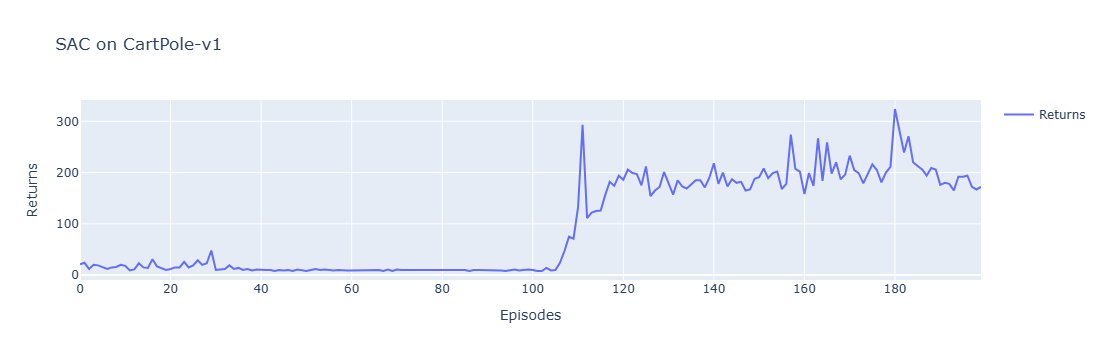

In [8]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('SAC_CartPole-v1_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='SAC on CartPole-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

In [9]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('SAC_CartPole-v1_mv_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='SAC on CartPole-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

***SAC** 在 **离散动作环境** 车杆下具有完美的收敛性能，并且其策略回报的曲线也十分稳定。**SAC** 可以在 **离散动作环境** 下 **平衡探索与利用***